In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms, utils

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ['A', 'B']
        self.register_buffer('mask', self.weight.data.clone())
        h = self.weight.size()[2]
        w = self.weight.size()[3]
        self.mask.fill_(1)
        # マスクタイプによる場合分け
        if mask_type == 'A': # 自分自身も見ない
          self.mask[:, :, h // 2, w // 2:] = 0
          self.mask[:, :, h // 2 + 1:] = 0
        else: # 自分自身は見る
          self.mask[:, :, h // 2, w // 2 + 1:] = 0
          self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, num_of_channels=32, n_layers=7, output_channels=256):
        super(PixelCNN, self).__init__()
        self.layers = nn.ModuleList()

        # 最初のブロック
        self.layers.append(MaskedConv2d(mask_type='A',
                                        in_channels=1,
                                        out_channels=num_of_channels,
                                        kernel_size=7,
                                        stride=1,
                                        padding=3,
                                        bias=False))
        self.layers.append(nn.BatchNorm2d(num_of_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # 後続のブロック
        for i in range(1, n_layers+1):
            self.layers.append(MaskedConv2d(mask_type='B',
                                            in_channels=num_of_channels,
                                            out_channels=num_of_channels,
                                            kernel_size=7,
                                            stride=1,
                                            padding=3,
                                            bias=False))
            self.layers.append(nn.BatchNorm2d(num_of_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.layers.append(nn.Conv2d(in_channels=num_of_channels,
                                     out_channels=output_channels,
                                     kernel_size=1))

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [ ]:
trainloader = data.DataLoader(datasets.MNIST('data', train=True,
                                             download=True,
                                             transform=transforms.ToTensor()),
                              batch_size=128, shuffle=True,
                              num_workers=1, pin_memory=True)

testloader = data.DataLoader(datasets.MNIST('data', train=False,
                                            download=True,
                                            transform=transforms.ToTensor()),
                             batch_size=128, shuffle=False,
                             num_workers=1, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 128016255.38it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110424515.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46810598.18it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17101013.26it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
num_of_layers = 4 # 畳み込み層の数
num_of_channels = 64 # チャネル数
num_of_epochs = 50
X_DIM = 28
NUM_OF_VALUES = 255
device = 'cuda:0'

In [ ]:
pixel_cnn = PixelCNN(num_of_channels, num_of_layers).to(device)

In [ ]:
optimizer = optim.Adam(list(pixel_cnn.parameters()))
criterion = nn.CrossEntropyLoss()
train_losses, test_losses = [], []
for epoch in range(num_of_epochs):
    # 学習
    train_errors = []
    pixel_cnn.train()
    for x, label in trainloader:
        x = x.to(device)
        target = (x[:,0] * NUM_OF_VALUES).long()
        loss = criterion(pixel_cnn(x), target)
        train_errors.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 評価
    with torch.no_grad():
        test_errors = []
        pixel_cnn.eval()
        for x, label in testloader:
            x = x.to(device)
            target = (x[:,0] * NUM_OF_VALUES).long()
            loss = criterion(pixel_cnn(x), target)
            teset_errors.append(loss.item())

        print(f'epoch: {epoch}/{num_of_epochs} train error: {np.mean(train_errors):0.3f} \
              test error {np.mean(test_errors):0.3f}')
    train_losses.append(np.mean(train_errors))
    test_losses.append(np.mean(test_errors))

epoch: 0/10 train error: 0.764               test error nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch: 1/10 train error: 0.746               test error nan
epoch: 2/10 train error: 0.737               test error nan
epoch: 3/10 train error: 0.731               test error nan
epoch: 4/10 train error: 0.725               test error nan
epoch: 5/10 train error: 0.719               test error nan
epoch: 6/10 train error: 0.714               test error nan
epoch: 7/10 train error: 0.707               test error nan
epoch: 8/10 train error: 0.700               test error nan
epoch: 9/10 train error: 0.693               test error nan


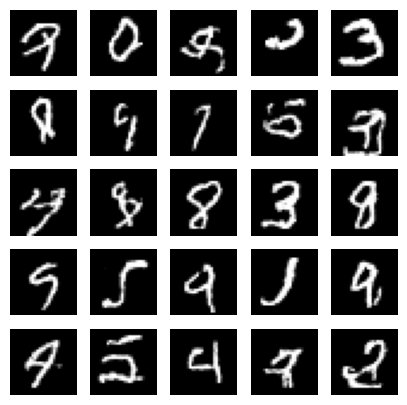

In [ ]:
sample = torch.Tensor(25, 1, X_DIM, X_DIM).to(device)
pixel_cnn.eval()
sample.fill_(0)
for i in range(X_DIM):
    for j in range(X_DIM):
        out = pixel_cnn(sample).to(device)
        probs = F.softmax(out[:, :, i, j], dim=1)
        sample[:, :, i, j] = torch.multinomial(probs, 1).float() / NUM_OF_VALUES

sample_array = sample.cpu().numpy().squeeze()
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(5, 5))
for i in range(25):
  idx = divmod(i, 10)
  ax[idx].imshow(sample_array[i]*255, cmap='gray')
  ax[idx].axis('off');
fig.show()